# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

Подключаемся к гугл диску.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Выгружаем датасеты.

In [ ]:
from os.path import exists
if not exists('train'):
    !unzip -q /content/gdrive/MyDrive/Colab_Notebooks/DLS_autumn_22/dz_5_simpsons/data/dataset.zip -d train
if not exists('test'):
    !unzip -q /content/gdrive/MyDrive/Colab_Notebooks/DLS_autumn_22/dz_5_simpsons/data/testset.zip -d test

In [ ]:
# !rm -rf train test

В нашем тесте будет 990 картинок, для которых вам будет необходимо предсказать класс.

Определяем нужные импорты.

In [ ]:
import pandas as pd
import numpy as np
import pickle
import torch
import math
import time

from skimage import io
from os.path import exists

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torch.nn as nn

import matplotlib.patches as patches
from matplotlib import colors, pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

Проверяем, есть ли видеокарта.

In [ ]:
!nvidia-smi

Wed Nov 23 17:28:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device('cuda')

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')

train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_labels = [path.parent.name for path in train_files]

In [ ]:
len(train_labels)

20933

Посмотрим на распределение классов в тестовой и валидационной выборке.

In [ ]:
train_df = pd.Series(train_labels).value_counts().sort_values().to_frame()
train_df.columns = ['count']
train_df

,count
lionel_hutz,3
troy_mcclure,8
disco_stu,8
miss_hoover,17
gil,27
fat_tony,27
otto_mann,32
sideshow_mel,40
agnes_skinner,42
rainier_wolfcastle,45


Видно, есть большой дисбаланс классов. Для `lionel_hutz` всего 3 картинки, а для `homer_simpson` целых 2246. Чтобы сетка смогла научиться распозновать всех персонажей, нужно чтобы на вход подавалось примерно равное количество картинок каждого из них. Пусть картинок каждого персонажа будет примерно 2000 (Гомера будет чуть-чуть больше). Добавим в таблицу информацию, сколько дополнительно картинок не хватает до выбранной границы. А также, сколько примерно картинок нужно получить из одной исходной.

In [ ]:
IMG_LIMIT = 2000

train_df['diff_limit'] = train_df['count'].map(lambda x: IMG_LIMIT - x if x < IMG_LIMIT else 0)
train_df['img_count_from_one'] = train_df.apply(lambda x: math.ceil(x['diff_limit'] / x['count']), axis=1)
train_df.head()

,count,diff_limit,img_count_from_one
lionel_hutz,3,1997,666
troy_mcclure,8,1992,249
disco_stu,8,1992,249
miss_hoover,17,1983,117
gil,27,1973,74


Для этого будем использовать аугментацию. В новой версии torch можно взять RandAugment, который будет случайным образом менять картинку. Поскольку в некоторых случаях нужно добавить много картинок, такое преобразование будет выгоднее, чем просто зеркалировать или центрировать.

In [ ]:
augmenter = transforms.RandAugment()

Приведем пример на нескольких картинках.

In [ ]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

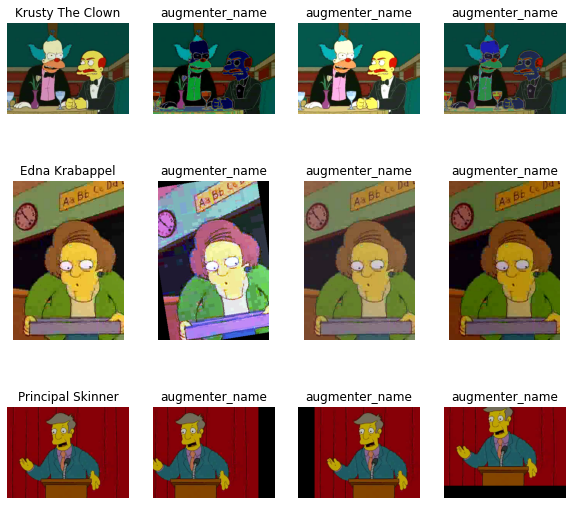

In [ ]:
n_examples = 3
n_augmneters = 3

fig, ax = plt.subplots(nrows=n_examples, ncols=(n_augmneters + 1), figsize=(10, 10))

for i in range(n_examples):
    random_character = int(np.random.uniform(0, len(train_files)))
    img_orig = load_image(train_files[random_character])
    img_label = train_files[random_character].parent.name

    img_label = ' '.join(map(lambda x: x.capitalize(), img_label.split('_')))
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')
        
    for j in range(n_augmneters):
        img_aug = augmenter(img_orig)
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title('random augmentation')
        ax[i][j + 1].axis('off')

In [ ]:
%%time
for image_path in tqdm(train_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = load_image(image_path)
    # if we don't need to add any images, we can continue without transformation
    if train_df.loc[character]['diff_limit'] <= 0:
        continue

    # если на одну картинку нужно добавить 
    if train_df.loc[character]['img_count_from_one'] < train_df.loc[character]['diff_limit']:
        new_img_count = train_df.loc[character]['img_count_from_one']
    else:
        new_img_count = train_df.loc[character]['diff_limit']
    train_df.loc[character]['diff_limit'] -= new_img_count
    
    for i in range(new_img_count):
        
        # ранее объявили augmenter = transforms.RandAugment()
        aug_img = augmenter(img)
        aug_img.save(f'{path}/{image_path.name.split(".")[0]}_{i}.jpg')

100%|██████████| 20933/20933 [09:13<00:00, 37.80it/s]

CPU times: user 9min 4s, sys: 10.6 s, total: 9min 15s
Wall time: 9min 13s


Теперь когда вся тестовая выборка сбалансированная, разделим на тестовую (на ней будем обучать) и валидационную.

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, stratify=train_val_labels)

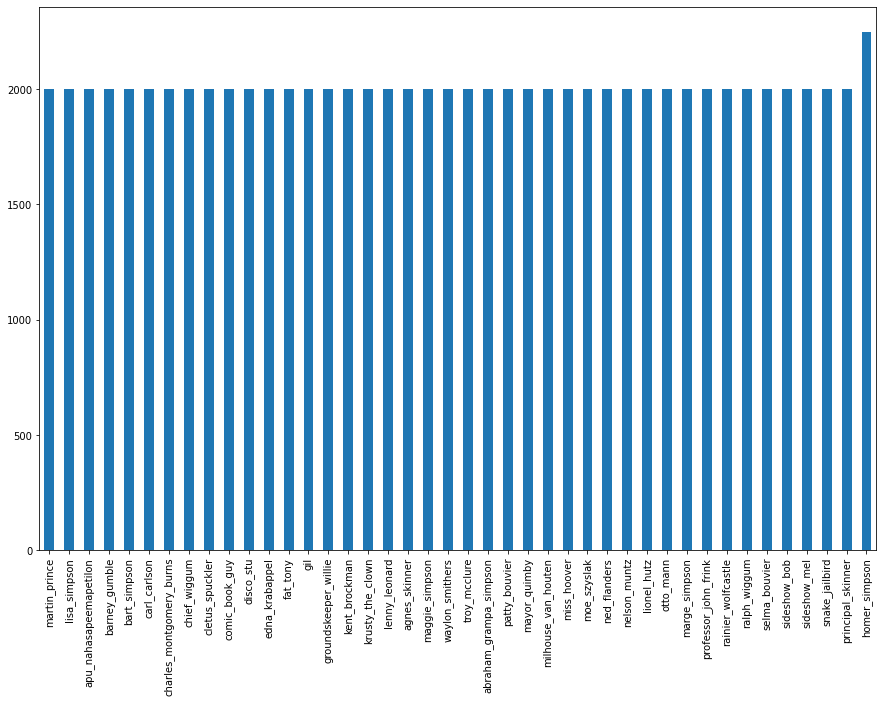

In [ ]:
train_val_check_df = pd.Series(train_val_labels).value_counts().sort_values().to_frame()
train_val_check_df.columns = ['count']

train_val_check_df['count'].plot.bar(figsize=(15, 10))
plt.show()

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

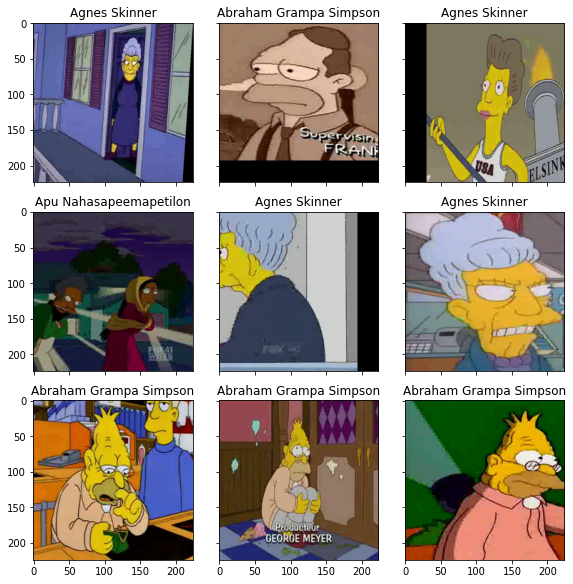

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True, constrained_layout=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = ' '.join(map(lambda x: x.capitalize(), 
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
class ModSimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(96 * 5 * 5, 1024),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(1024, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        logits = self.fc2(x)
        return logits

Добавим дополнительно scheduler, чтобы у нас уменьшался learning_rate.

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train(True)
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    since = time.time()
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = '\nEpoch: {ep:03d} | ' + \
            'train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} | ' + \
            'train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}'

    with tqdm(desc='epoch', total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()
        scheduler = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, 
                                           t_loss=train_loss, v_loss=val_loss, 
                                           t_acc=train_acc, v_acc=val_acc))
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
#check_cnn = SimpleCnn(n_classes).to(DEVICE)
check_cnn = ModSimpleCnn(n_classes).to(DEVICE)

print('we will classify :{}'.format(n_classes))
print('-'*60)
print(check_cnn)

we will classify :42
------------------------------------------------------------
ModSimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
#history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)
history = train(train_dataset, val_dataset, model=check_cnn, epochs=20, batch_size=256)

epoch:   5%|▌         | 1/20 [10:42<3:23:29, 642.59s/it]


Epoch: 001 | train_loss: 2.1497 val_loss 1.1707 | train_acc 0.4415 val_acc 0.6938


epoch:  10%|█         | 2/20 [20:58<3:08:08, 627.16s/it]


Epoch: 002 | train_loss: 0.8231 val_loss 0.7233 | train_acc 0.7780 val_acc 0.8090


epoch:  15%|█▌        | 3/20 [31:06<2:55:06, 618.02s/it]


Epoch: 003 | train_loss: 0.4391 val_loss 0.6142 | train_acc 0.8755 val_acc 0.8447


epoch:  20%|██        | 4/20 [40:48<2:41:00, 603.76s/it]


Epoch: 004 | train_loss: 0.2529 val_loss 0.6065 | train_acc 0.9252 val_acc 0.8566


epoch:  25%|██▌       | 5/20 [50:20<2:28:06, 592.45s/it]


Epoch: 005 | train_loss: 0.1543 val_loss 0.6528 | train_acc 0.9526 val_acc 0.8584


epoch:  30%|███       | 6/20 [59:56<2:16:54, 586.76s/it]


Epoch: 006 | train_loss: 0.0412 val_loss 0.6043 | train_acc 0.9890 val_acc 0.8839


epoch:  35%|███▌      | 7/20 [1:09:41<2:07:03, 586.43s/it]


Epoch: 007 | train_loss: 0.0137 val_loss 0.6445 | train_acc 0.9981 val_acc 0.8858


epoch:  40%|████      | 8/20 [1:19:24<1:57:03, 585.25s/it]


Epoch: 008 | train_loss: 0.0072 val_loss 0.6834 | train_acc 0.9993 val_acc 0.8866


epoch:  45%|████▌     | 9/20 [1:29:00<1:46:47, 582.47s/it]


Epoch: 009 | train_loss: 0.0043 val_loss 0.7195 | train_acc 0.9998 val_acc 0.8871


epoch:  50%|█████     | 10/20 [1:38:40<1:36:55, 581.58s/it]


Epoch: 010 | train_loss: 0.0029 val_loss 0.7507 | train_acc 0.9999 val_acc 0.8873


epoch:  55%|█████▌    | 11/20 [1:48:22<1:27:13, 581.55s/it]


Epoch: 011 | train_loss: 0.0020 val_loss 0.7546 | train_acc 0.9999 val_acc 0.8881


epoch:  60%|██████    | 12/20 [1:58:01<1:17:27, 580.93s/it]


Epoch: 012 | train_loss: 0.0018 val_loss 0.7584 | train_acc 0.9999 val_acc 0.8882


epoch:  65%|██████▌   | 13/20 [2:07:51<1:08:06, 583.74s/it]


Epoch: 013 | train_loss: 0.0017 val_loss 0.7623 | train_acc 1.0000 val_acc 0.8884


epoch:  70%|███████   | 14/20 [2:17:50<58:49, 588.22s/it]


Epoch: 014 | train_loss: 0.0016 val_loss 0.7669 | train_acc 0.9999 val_acc 0.8881


epoch:  75%|███████▌  | 15/20 [2:28:08<49:46, 597.33s/it]


Epoch: 015 | train_loss: 0.0016 val_loss 0.7719 | train_acc 1.0000 val_acc 0.8883


epoch:  80%|████████  | 16/20 [2:38:17<40:02, 600.70s/it]


Epoch: 016 | train_loss: 0.0015 val_loss 0.7725 | train_acc 1.0000 val_acc 0.8883


epoch:  85%|████████▌ | 17/20 [2:48:21<30:04, 601.63s/it]


Epoch: 017 | train_loss: 0.0015 val_loss 0.7730 | train_acc 1.0000 val_acc 0.8884


epoch:  90%|█████████ | 18/20 [2:58:34<20:10, 605.32s/it]


Epoch: 018 | train_loss: 0.0015 val_loss 0.7738 | train_acc 1.0000 val_acc 0.8885


epoch:  95%|█████████▌| 19/20 [3:08:50<10:08, 608.29s/it]


Epoch: 019 | train_loss: 0.0015 val_loss 0.7746 | train_acc 1.0000 val_acc 0.8884


epoch: 100%|██████████| 20/20 [3:18:54<00:00, 596.74s/it]


Epoch: 020 | train_loss: 0.0014 val_loss 0.7755 | train_acc 1.0000 val_acc 0.8885
Training complete in 198m 55s
Best val Acc: 0.888487


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

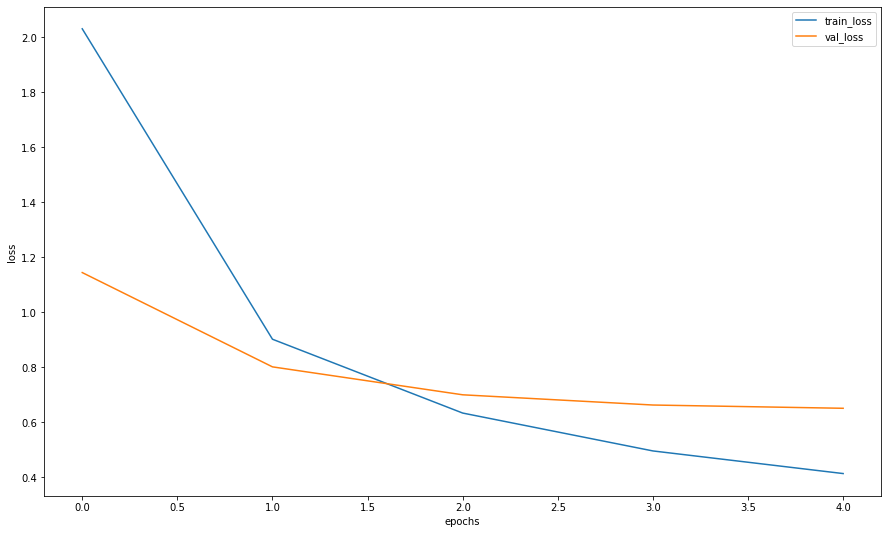

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

Получим предсказания для одной картинки

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0, 1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(check_cnn, ex_img.unsqueeze(0))

In [ ]:
# print(probs_im)

In [ ]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(check_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims, -1)

actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
val_f1_score = f1_score(actual_labels, y_pred, average='weighted')

print(f'val_f1_score = {val_f1_score}')

val_f1_score = 0.9073333333333334


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

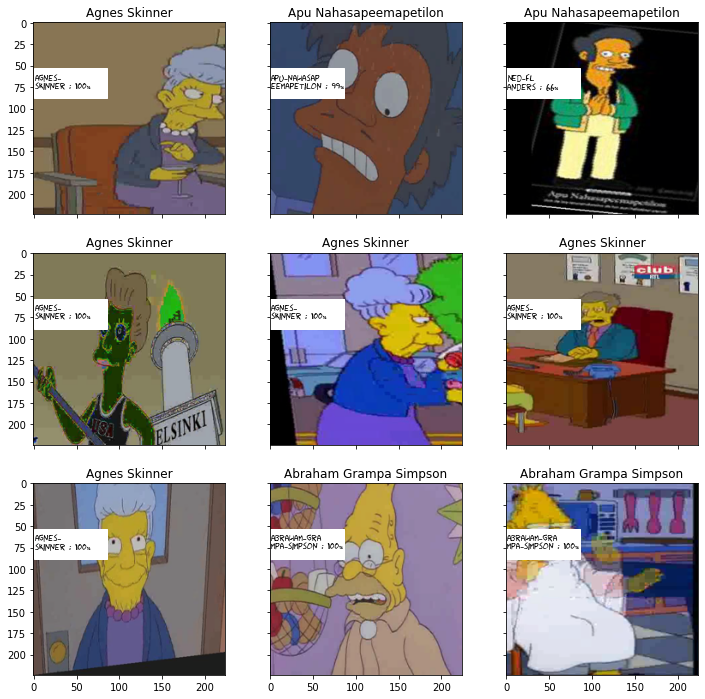

In [ ]:


fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = ' '.join(map(lambda x: x.capitalize(),
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)
            
    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family('fantasy')
    prob_pred = predict_one_sample(check_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred) * 100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top', fontsize=8, color='black', fontweight='bold')

### Submit на Kaggle

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(check_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('/content/gdrive/MyDrive/Colab_Notebooks/DLS_autumn_22/dz_5_simpsons/check_mod_cnn_baseline.csv', index=False)

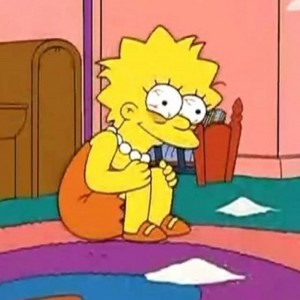